<a href="https://colab.research.google.com/github/gwohlgen/colab/blob/master/fastai_AT_court_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First test of using **FastAI** with the **Austrian court cases dataset**.
This dataset is: **single-label, multi-class, German language**.
What is done:


1.   Create DataBunch
2.   Create data_lm .. data to train the language model
3.   Finetune the AWD_LSTM with the data_lm .. this takes a long time
4.   Train a classifier with the encoder part of the trained language model and the classification dataset








In [0]:
# init

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.text import *


In [2]:
# get the data
!wget https://aic.ai.wu.ac.at/~wohlg/at_court_cases.csv.zip
!unzip at_court_cases.csv.zip
!ls
!mkdir models

--2019-06-02 09:01:32--  https://aic.ai.wu.ac.at/~wohlg/at_court_cases.csv.zip
Resolving aic.ai.wu.ac.at (aic.ai.wu.ac.at)... 137.208.107.25
Connecting to aic.ai.wu.ac.at (aic.ai.wu.ac.at)|137.208.107.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29973287 (29M) [application/zip]
Saving to: ‘at_court_cases.csv.zip’

at_court_cases.csv. 100%[===================>]  28.58M  6.53MB/s    in 5.4s    

2019-06-02 09:01:39 (5.28 MB/s) - ‘at_court_cases.csv.zip’ saved [29973287/29973287]

Archive:  at_court_cases.csv.zip
  inflating: at_court_cases.csv      
at_court_cases.csv  at_court_cases.csv.zip  sample_data


In [3]:
from pathlib import Path
p = Path('at_court_cases.csv')

df = pd.read_csv('at_court_cases.csv')
print(df.head())
print(df['text'][1])

                            label                                               text
0            __label__strafrecht     Gericht OGH Entscheidungsdatum 13.11.2013 Ge...
1  __label__zivilverfahrensrecht     Gericht OGH Entscheidungsdatum 10.05.2011 Ge...
2            __label__strafrecht     Gericht OGH Entscheidungsdatum 12.08.2014 Ge...
3  __label__zivilverfahrensrecht     Gericht OGH Entscheidungsdatum 20.12.2010 Ge...
4            __label__strafrecht     Gericht OGH Entscheidungsdatum 14.03.2018 Ge...
  Gericht OGH Entscheidungsdatum 10.05.2011 Geschäftszahl 4Ob67/11y Kopf Der Oberste Gerichtshof hat als Revisionsgericht durch die Senatspräsidentin Dr. Schenk als Vorsitzende und die Hofräte Dr. Vogel, Dr. Jensik, Dr. Musger und Dr. Schwarzenbacher als weitere Richter in der Rechtssache der klagenden Partei ***** Rechtsanwaltskammer, *****, vertreten durch Dr. Bertram Grass und Mag. Christoph Dorner, Rechtsanwälte in Bregenz, gegen die beklagte Partei Arbeiterkammer *****, vertreten 

In [4]:
!ls -ltar


total 125308
-rw-rw-r-- 1 root root 98318395 May 12 08:59 at_court_cases.csv
-rw-r--r-- 1 root root 29973287 May 12 09:06 at_court_cases.csv.zip
drwxr-xr-x 1 root root     4096 May 24 16:08 sample_data
drwxr-xr-x 1 root root     4096 May 30 16:09 .config
drwxr-xr-x 1 root root     4096 Jun  2 08:59 ..
drwxr-xr-x 2 root root     4096 Jun  2 09:01 models
drwxr-xr-x 1 root root     4096 Jun  2 09:01 .


In [0]:
data_lm = TextDataBunch.from_csv(Path('.'), 'at_court_cases.csv')

In [0]:
data_lm.save()
#!ls


In [7]:
path = Path('.')
data = TextClasDataBunch.from_csv(path, 'at_court_cases.csv')
data.show_batch()

text,target
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum xxunk xxmaj geschäftszahl 14os143 / 09z xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 23 . xxmaj dezember 2010 durch den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj lässig als xxmaj vorsitzenden , die xxmaj hofrätin des xxmaj obersten xxmaj gerichtshofs xxmaj mag . xxmaj hetlinger , den xxmaj hofrat des xxmaj obersten xxmaj",__label__strafrecht
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 14.01.2015 xxmaj geschäftszahl 15os52 / 14 g ( 15os53 / 14d ) xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 14 . xxmaj jänner 2015 durch den xxmaj senatspräsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj prof . xxmaj dr. xxmaj danek als xxmaj vorsitzenden , den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj mag .",__label__strafrecht
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum xxunk xxmaj geschäftszahl xxunk / 10 g xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat als xxmaj revisionsgericht durch die xxmaj senatspräsidentin des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj huber als xxmaj vorsitzende und die xxmaj hofräte des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj schaumüller , xxmaj dr. xxmaj hoch , xxmaj dr. xxmaj kalivoda und",__label__konsumentenschutz
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 06.12.2016 xxmaj geschäftszahl 17os14 / 16 m xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 6 . xxmaj dezember 2016 durch den xxmaj präsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj hon .- xxmaj prof . xxmaj dr. xxmaj ratz als xxmaj vorsitzenden , die xxmaj senatspräsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj prof . xxmaj dr.",__label__strafrecht
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 19.03.2015 xxmaj geschäftszahl xxunk / 14b xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat durch den xxmaj senatspräsidenten xxmaj hon .- xxmaj prof . xxmaj dr. xxmaj sailer als xxmaj vorsitzenden sowie die xxmaj hofräte xxmaj univ .- xxmaj prof . xxmaj dr. xxmaj bydlinski , xxmaj mag . xxmaj wurzer , xxmaj mag . xxmaj",__label__zivilverfahrensrecht


In [8]:
data.vocab.itos[:200]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '\xa0',
 ',',
 '.',
 'der',
 'die',
 'des',
 'und',
 ')',
 '(',
 'in',
 '§',
 '/',
 '-',
 '5',
 'den',
 'nicht',
 'zu',
 'i',
 'm',
 '*',
 'das',
 'abs',
 '1',
 'von',
 'dem',
 'auf',
 'mit',
 'nach',
 'als',
 ';',
 'ist',
 'für',
 'eine',
 'dass',
 'auch',
 'durch',
 ':',
 '2',
 'einer',
 'vom',
 'zur',
 'sich',
 '„',
 '“',
 'z',
 'dr.',
 'ein',
 'über',
 'aus',
 'gegen',
 'an',
 'sei',
 'oder',
 '3',
 'stpo',
 'hat',
 'ob',
 'bei',
 'es',
 'justiz',
 'werden',
 'ris',
 'sie',
 'er',
 'eines',
 'am',
 '4',
 'nur',
 'wird',
 'fall',
 's',
 'ogh',
 'stgb',
 'wurde',
 'zum',
 'rz',
 'einen',
 'vgl',
 'beklagten',
 'sowie',
 'partei',
 'obersten',
 'einem',
 'angeklagten',
 'entscheidung',
 'diese',
 'habe',
 'wenn',
 '\xa0 ',
 '10',
 'keine',
 'urteil',
 'unter',
 'gerichtshofs',
 '9',
 'daher',
 'wegen',
 'vor',
 '6',
 'klägerin',
 'dieser',
 'war',
 'mag',
 'eur',
 'on',
 'kläger',
 'beklagte',
 

In [9]:
data.train_ds[0][0]

Text xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 27.02.2012 xxmaj geschäftszahl 9oba158 / 11 t xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat als xxmaj revisionsgericht in xxmaj arbeits- und xxmaj sozialrechtssachen durch den xxmaj vizepräsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj dr.   xxmaj rohrer als xxmaj vorsitzenden und die xxmaj hofräte des xxmaj obersten xxmaj gerichtshofs xxmaj dr.   xxmaj hopf und xxmaj hon .- xxmaj prof .   xxmaj dr.   xxmaj kuras sowie die fachkundigen xxmaj laienrichter xxup kr   xxmaj mag .   xxmaj paul xxmaj kunsky und xxmaj dr.   xxmaj klaus xxmaj mayr als weitere xxmaj richter in der xxmaj arbeitsrechtssache der klagenden xxmaj partei xxmaj josef z xxrep 5 * , vertreten durch xxmaj klein , xxmaj wuntschek & xxmaj partner xxmaj rechtsanwälte gmbh in xxmaj graz , wider die beklagte xxmaj partei h xxrep 5 * , vertreten durch xxmaj dr.   xxmaj thomas xxmaj stampfer , xxmaj dr.   xxmaj christoph xxmaj orgler xxmaj rechtsanwälte

In [0]:
data.train_ds[0][0].data[:10]


array([    2,     5,   126,     6,    80,     5,   153, 14691,     5,   152])

In [0]:
#data = (TextList.from_csv(path, 'at_court_cases.csv', cols='text')
#                .split_from_df(col=2)
#                .label_from_df(cols=0)
#                .databunch())

# I think everything above was just to play around -- we can just start here!!


In [0]:
import pandas as pd

In [11]:
df = pd.read_csv('at_court_cases.csv')
print(df.label)
df.head()

0                  __label__strafrecht 
1        __label__zivilverfahrensrecht 
2                  __label__strafrecht 
3        __label__zivilverfahrensrecht 
4                  __label__strafrecht 
5                __label__arbeitsrecht 
6                  __label__strafrecht 
7                __label__arbeitsrecht 
8        __label__zivilverfahrensrecht 
9                  __label__strafrecht 
10               __label__arbeitsrecht 
11       __label__zivilverfahrensrecht 
12              __label__familienrecht 
13               __label__handelsrecht 
14       __label__zivilverfahrensrecht 
15       __label__zivilverfahrensrecht 
16                 __label__strafrecht 
17                __label__sozialrecht 
18       __label__zivilverfahrensrecht 
19               __label__arbeitsrecht 
20                 __label__strafrecht 
21                __label__sozialrecht 
22                       __label__auto 
23       __label__zivilverfahrensrecht 
24               __label__arbeitsrecht 


,label,text
0,__label__strafrecht,Gericht OGH Entscheidungsdatum 13.11.2013 Ge...
1,__label__zivilverfahrensrecht,Gericht OGH Entscheidungsdatum 10.05.2011 Ge...
2,__label__strafrecht,Gericht OGH Entscheidungsdatum 12.08.2014 Ge...
3,__label__zivilverfahrensrecht,Gericht OGH Entscheidungsdatum 20.12.2010 Ge...
4,__label__strafrecht,Gericht OGH Entscheidungsdatum 14.03.2018 Ge...


In [0]:
print(df.groupby('label').nunique())
print("\n Number of classes:", df.label.nunique())

                                label  text
label                                      
__label__angestellter               1    35
__label__arbeitgeber                1   618
__label__arbeitnehmer               1   659
__label__arbeitsrecht               1  1273
__label__auto                       1  1778
__label__familienrecht              1   466
__label__gesellschaftsrecht         1   312
__label__handelsrecht               1   312
__label__konsumentenschutz          1   146
__label__schadenersatz              1   179
__label__sozialrecht                1   747
__label__strafrecht                 1  4536
__label__urheberrecht               1    74
__label__zivilverfahrensrecht       1  1346

 Number of classes: 14


In [0]:
df_text = df[['text']].copy()
print(df_text.head())
print(df_text.columns)

                                                text
0    Gericht OGH Entscheidungsdatum 13.11.2013 Ge...
1    Gericht OGH Entscheidungsdatum 10.05.2011 Ge...
2    Gericht OGH Entscheidungsdatum 12.08.2014 Ge...
3    Gericht OGH Entscheidungsdatum 20.12.2010 Ge...
4    Gericht OGH Entscheidungsdatum 14.03.2018 Ge...
Index(['text'], dtype='object')


In [0]:
%%time

bs=48
data_lm = (TextList.from_df(df_text)
           #Inputs: all the text files in path
            # .filter_by_folder(include=['.']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')
print('done')

done
CPU times: user 15.9 s, sys: 2.81 s, total: 18.7 s
Wall time: 3min 26s


In [0]:
path = Path('.')
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"gerichtshofs xxmaj dr. xxmaj bachner - xxmaj foregger , xxmaj dr. xxmaj michel - xxmaj kwapinski und xxmaj mag . xxmaj fürnkranz als weitere xxmaj richter in xxmaj gegenwart der xxmaj richteramtsanwärterin mmag . xxmaj vasak als xxmaj schriftführerin in der xxmaj strafsache gegen xxmaj xxunk a xxrep 5 * wegen des xxmaj verbrechens des xxmaj suchtgifthandels nach § 28a xxmaj abs 1 zweiter"
1,"6 / xxunk , nach xxmaj anhörung der xxmaj generalprokuratur in nichtöffentlicher xxmaj sitzung zu xxmaj recht erkannt : xxmaj spruch xxmaj die xxmaj nichtigkeitsbeschwerde wird zurückgewiesen . xxmaj aus deren xxmaj anlass wird das angefochtene xxmaj urteil aufgehoben und die xxmaj sache zu neuer xxmaj verhandlung und xxmaj entscheidung an das xxmaj landesgericht xxmaj innsbruck verwiesen . xxmaj mit seiner xxmaj berufung wird der xxmaj angeklagte"
2,"weitere xxmaj fragen wurden nicht gestellt . xxmaj rechtliche xxmaj beurteilung xxmaj gegen xxmaj punkt 2 . / des xxmaj schuldspruchs richtet sich die auf z 6 und 8 des § 345 xxmaj abs 1 stpo gestützte xxmaj nichtigkeitsbeschwerde des xxmaj angeklagten , der keine xxmaj berechtigung zukommt . xxmaj unter xxmaj hinweis auf die xxmaj ausführungen des xxmaj sachverständigen , wonach der xxmaj affekt mit"
3,"2010 , in eventu ab 1 . 1 . 2011 . 2 . xxmaj die xxup vo ( xxup ewg ) xxmaj nr 1408 / 71 wurde mit dem xxmaj beginn der xxmaj anwendung der xxup vo ( xxup eg ) xxmaj nr 883 / 2004 am 1 . 5 . 2010 grundsätzlich aufgehoben . xxmaj sie blieb jedoch gemäß xxmaj art"
4,"nicht verfügen durfte , mit dem xxmaj vorsatz unterdrückt , zu verhindern , dass sie i m xxmaj rechtsverkehr zum xxmaj beweis eines xxmaj rechtes , eines xxmaj rechtsverhältnisses oder einer xxmaj tatsache gebraucht werden , und zwar mehrere durch die unter xxmaj punkt xxup i. xxup b. 1 . d. angeführte xxmaj tat erlangte xxmaj urkunden ; xxup iii . am 5 ."


## Create a learner from a pretrained model / architecture
Default: AWD_LSTM (which includes a pretrained Wikidata103 model (for English))

TODO: try TransformerXL

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#learn = language_model_learner(data_lm, TransformerXL, pretrained=False) # ?? , drop_mult=0.3)

In [0]:
%%time

learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 15.9 s, sys: 12.8 s, total: 28.7 s
Wall time: 30.5 s


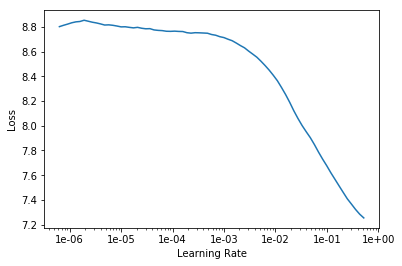

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-1, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.652426,3.207759,0.463898,33:16


CPU times: user 18min 23s, sys: 14min 27s, total: 32min 51s
Wall time: 33min 16s


In [0]:
learn.save('fit_head')

In [0]:
## continue here -- check that fit_head is in models
!mv fit_head.pth models
!ls models

fit_head.pth


In [0]:
learn.load('fit_head');

In [0]:
#!du -sh *
#from google.colab import files
#files.download('data_lm.pkl')
#files.download('data_save.pkl')
#files.download('models/fit_head.pth')


In [0]:
learn.unfreeze()

In [0]:
epochs = 3 # orig: 10
learn.fit_one_cycle(epochs, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.652942,2.743430,0.512871,1:07:06
1,2.477582,2.439667,0.546296,1:07:03
2,2.291646,2.243375,0.572476,1:07:07


In [0]:
learn.save('fine_tuned')

In [0]:

learn.load('fine_tuned');

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:327: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


In [0]:

#from google.colab import files
#files.download('models/fine_tuned.pth')

In [0]:
# test lang model
TEXT = "Der Angeklagte stahl den Wagen am"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))


Der Angeklagte stahl den Wagen am 1 .   März   2010 in Wiener Neustadt , sowie für den Fall , dass sie seit der A   2011 mit dem Pkw „ n ***** “““““ nochnochnochnochnoch nichtnichtnichtnichtnicht ininininin
Der Angeklagte stahl den Wagen am 24 . März 2004 mit Ablauf der Rekursfrist am 13 . Dezember 2008 in Wien durch einen August nach Österreich durch den Arzt Dr.   Richard s *****


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:

!ls -l model
print('let us grab the encoder!')

In [0]:
data_clas = (TextList.from_csv(Path('.'), 'at_court_cases.csv', vocab=data_lm.vocab, cols='text')
             #grab all the text files in path
             #wohlg: .split_by_folder(valid='test')
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)             
             #wohlg: .label_from_folder(classes=['neg', 'pos'])
             .label_from_df(cols='label')
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [0]:
data_clas.show_batch()
#data_clas.label_list




text,target
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum xxunk xxmaj geschäftszahl xxunk / 09z xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 23 . xxmaj dezember 2010 durch den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj lässig als xxmaj vorsitzenden , die xxmaj hofrätin des xxmaj obersten xxmaj gerichtshofs xxmaj mag . xxmaj hetlinger , den xxmaj hofrat des xxmaj obersten xxmaj",__label__strafrecht
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 14.01.2015 xxmaj geschäftszahl 15os52 / 14 g ( 15os53 / 14d ) xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 14 . xxmaj jänner 2015 durch den xxmaj senatspräsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj prof . xxmaj dr. xxmaj danek als xxmaj vorsitzenden , den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj mag .",__label__strafrecht
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum xxunk xxmaj geschäftszahl xxunk / 09z xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 22 . xxmaj dezember 2010 durch den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj lässig als xxmaj vorsitzenden , die xxmaj hofrätin des xxmaj obersten xxmaj gerichtshofs xxmaj mag . xxmaj hetlinger , den xxmaj hofrat des xxmaj obersten xxmaj",__label__strafrecht
xxbos xxmaj gericht xxup ogh xxmaj rechtssatznummer xxup xxunk xxmaj entscheidungsdatum xxunk xxmaj geschäftszahl xxmaj xxunk / 53 ; xxunk / 55 ; 6ob179 / 59 ; xxunk / 59 ; xxunk / 61 ; 6ob204 / 61 ; xxunk / 62 ; 8ob33 / 63 ; xxunk / 63 ; 6ob28 / 64 ; xxunk / 64 ; xxunk / 65 ; 8ob219 / 65 ; xxunk / 65,__label__auto
"xxbos xxmaj gericht xxup ogh xxmaj entscheidungsdatum 22.05.2013 xxmaj geschäftszahl xxunk / 13f xxmaj kopf xxmaj der xxmaj oberste xxmaj gerichtshof hat am 22 . xxmaj mai 2013 durch den xxmaj senatspräsidenten des xxmaj obersten xxmaj gerichtshofs xxmaj dr. xxmaj danek als xxmaj vorsitzenden , den xxmaj hofrat des xxmaj obersten xxmaj gerichtshofs xxmaj mag . xxmaj lendl und die xxmaj hofrätinnen des xxmaj obersten xxmaj",__label__strafrecht


In [0]:
################ check if all ok .. data_clas ...
!mv fine_tuned_enc.pth models

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [0]:

learn.lr_find()

In [0]:

learn.recorder.plot()

In [0]:
#learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
learn.fit_one_cycle(2, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.045188,0.834832,0.730032,11:18
1,0.909289,0.767916,0.744010,10:58


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-2/(2.6**4),2e-2), moms=(0.8,0.7))
#learn.fit_one_cycle(1, slice(5e-1/(2.6**4),5e-1), moms=(0.8,0.7))
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.697234,0.511395,0.809105,12:02


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:

learn.freeze_to(-3)
#learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.592018,0.492199,0.816294,14:30
1,0.572953,0.469279,0.829473,16:33
2,0.541776,0.476001,0.818690,13:56
3,0.539216,0.468713,0.823083,14:08


In [0]:
learn.save('third')

In [0]:
learn.load('third');

/usr/local/lib/python3.6/dist-packages/fastai/basic_train.py:327: UserWarning: Wasn't able to properly load the optimizer state again.
  except: warn("Wasn't able to properly load the optimizer state again.")


In [0]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/(2.6**4),2e-3), moms=(0.8,0.7))
#learn.fit_one_cycle(2, slice(3e-4/(2.6**4),3e-4), moms=(0.8,0.7))



epoch,train_loss,valid_loss,accuracy,time
0,0.553947,0.472038,0.820288,18:25
1,0.489642,0.469652,0.823482,16:29
2,0.536177,0.449290,0.825080,16:40


In [0]:
print(learn.predict("Romania and Bulgaria aim in particular to liberalise trade in products covered by the common organisation of the market concerned!"))
print(learn.predict("Standing Committee on Seeds and Propagating Material for Agriculture"))
